In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [2]:
DATASET_LOCATION = "../datasets/small-imc21/"
cpu_df = pd.read_csv(DATASET_LOCATION + "s_VM_CPU.csv.gz", compression="gzip")

In [3]:
pm_subset_df = pd.read_csv(DATASET_LOCATION + "s_PM.csv.gz", nrows=10, compression="gzip")
rtt_subset_df = pd.read_csv(DATASET_LOCATION+ "/s_SITE_RTT.csv.gz", nrows=10, compression="gzip")
vm_subset_df = pd.read_csv(DATASET_LOCATION+ "/s_VM.csv.gz", nrows=10, compression="gzip")
vm_bw_subset_df = pd.read_csv(DATASET_LOCATION + "/s_VM_BANDWIDTH.csv.gz", nrows=10, compression="gzip")
vm_cpu_subset_df = pd.read_csv(DATASET_LOCATION + "/s_VM_CPU.csv.gz", nrows=10, compression="gzip")

print(pm_subset_df.columns)
print(rtt_subset_df.columns)
print(vm_subset_df.columns)
print(vm_bw_subset_df.columns)
print(vm_cpu_subset_df.columns)

del pm_subset_df, rtt_subset_df, vm_subset_df, vm_bw_subset_df, vm_cpu_subset_df

Index(['pm_name', 'site_id', 'cores', 'memory', 'storage'], dtype='object')
Index(['from_site_id', 'to_site_id', 'rtt', 'loss', 'type', 'biz_ts',
       'biz_time', 'create_time'],
      dtype='object')
Index(['vm_id', 'uid', 'pm_name', 'site_id', 'status', 'image_id', 'cores',
       'memory', 'storage', 'os_type', 'os_name', 'start_time', 'end_time'],
      dtype='object')
Index(['vm_id', 'site_id', 'pub_down_flow', 'pub_up_flow', 'pub_down_bw',
       'pub_up_bw', 'pri_down_flow', 'pri_up_flow', 'pri_down_bw', 'pri_up_bw',
       'report_ts'],
      dtype='object')
Index(['vm_id', 'site_id', 'cpu_rate', 'report_ts'], dtype='object')


In [4]:
pm_df = pd.read_csv(DATASET_LOCATION + "s_PM.csv.gz", compression="gzip")
rtt_df = pd.read_csv(DATASET_LOCATION+ "/s_SITE_RTT.csv.gz", compression="gzip")
vm_df = pd.read_csv(DATASET_LOCATION+ "/s_VM.csv.gz", compression="gzip")
vm_bw_df = pd.read_csv(DATASET_LOCATION + "/s_VM_BANDWIDTH.csv.gz", compression="gzip")
vm_cpu_df = pd.read_csv(DATASET_LOCATION + "/s_VM_CPU.csv.gz", compression="gzip")


In [5]:
# Verify that all datasets have the same site IDs
unique_from_site_ids  = sorted(rtt_df["from_site_id"].unique())
unique_to_site_ids = sorted(rtt_df["to_site_id"].unique())
unique_pm_site_ids = sorted(pm_df["site_id"].unique())
unique_vm_site_ids = sorted(vm_df["site_id"].unique())
unique_vm_bw_site_ids = sorted(vm_bw_df["site_id"].unique())
unique_vm_cpu_site_ids = sorted(vm_cpu_df["site_id"].unique())

print(unique_from_site_ids)
print(unique_to_site_ids)
print(unique_pm_site_ids)
print(unique_vm_site_ids)
print(unique_vm_bw_site_ids)
print(unique_vm_cpu_site_ids)

['chengdu-cmcc', 'chongqing-unicom', 'dalian-unicom', 'guangzhou-cmcc', 'guangzhou-telecom', 'kunming-telecom', 'nanjing-cmcc', 'shenzhen-telecom_unicom_cmcc', 'wuhan-cmcc', 'wuhan-telecom', 'wuhan-unicom', 'wuxi-telecom_unicom_cmcc', 'xian-unicom']
['chengdu-cmcc', 'chongqing-unicom', 'dalian-unicom', 'guangzhou-cmcc', 'guangzhou-telecom', 'kunming-telecom', 'nanjing-cmcc', 'shenzhen-telecom_unicom_cmcc', 'wuhan-cmcc', 'wuhan-telecom', 'wuhan-unicom', 'wuxi-telecom_unicom_cmcc', 'xian-unicom']
['chengdu-cmcc', 'chongqing-unicom', 'dalian-unicom', 'guangzhou-cmcc', 'guangzhou-telecom', 'kunming-telecom', 'nanjing-cmcc', 'shenzhen-telecom_unicom_cmcc', 'wuhan-cmcc', 'wuhan-telecom', 'wuhan-unicom', 'wuxi-telecom_unicom_cmcc', 'xian-unicom']
['chengdu-cmcc', 'chongqing-unicom', 'dalian-unicom', 'guangzhou-cmcc', 'guangzhou-telecom', 'kunming-telecom', 'nanjing-cmcc', 'shenzhen-telecom_unicom_cmcc', 'wuhan-cmcc', 'wuhan-telecom', 'wuhan-unicom', 'wuxi-telecom_unicom_cmcc', 'xian-unicom', 

In [6]:
drop_row_indices = []
# Identify the rows to drop from VM df as site  zhangjiagang-telecom is not present in other data sets
for index, row in vm_df[vm_df["site_id"]=="zhangjiagang-telecom"].iterrows():
    vm_id = row["vm_id"]
    if not vm_id in vm_bw_df["vm_id"].values and not vm_id in vm_cpu_df["vm_id"].values:
        drop_row_indices.append(index)
    else:
        print("VM ID = {} found in CPU / BW datasets".format(vm_id))

print("Row indices to be dropped = {}".format(drop_row_indices))
vm_df.drop(labels=drop_row_indices, inplace=True)
assert len(vm_df[vm_df["site_id"]=="zhangjiagang-telecom"]) == 0

Row indices to be dropped = [2, 13, 26, 31]


In [7]:
pm_df_sites = pm_df["site_id"].str.split('-', expand=True)
pm_df_sites.rename(columns={0: "city", 1: "site_location"}, inplace=True)
pm_df = pd.concat([pm_df, pm_df_sites], axis=1)
print(pm_df.columns)

print("Characteristics of Physical machines in each city")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pm_df.groupby("city").agg({
        "pm_name": "count",
        "memory": [min, max, sum],
        "cores": [min, max, sum],
        "storage": [min, max, sum],
    }))



Index(['pm_name', 'site_id', 'cores', 'memory', 'storage', 'city',
       'site_location'],
      dtype='object')
Characteristics of Physical machines in each city
          pm_name  memory                   cores              storage  \
            count     min     max       sum   min  max   sum       min   
city                                                                     
chengdu        35       0  386368  11205265     0  144  4106    819935   
chongqing      21       0  515759   9020586     0  115  1812    820102   
dalian         37  257727  386248  12361409    64  115  3481     50268   
guangzhou      71       0  386248  23309791     0  144  7643    819934   
kunming        26  257727  386248   9399843    64  115  2736    901027   
nanjing        34       0  386395  12747040     0  115  3574    819934   
shenzhen       40  128743  128807   5149784    32   32  1280  28342811   
wuhan          84  257727  386248  28844144    64  130  8716    900132   
wuxi           20  354

In [8]:
print("Number of VMs deployed per customer per site")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(vm_df.groupby(["uid", "site_id"])["vm_id"].count())


Number of VMs deployed per customer per site
uid    site_id                     
2088   chengdu-cmcc                     1
       wuhan-cmcc                       1
       wuhan-telecom                    1
       wuhan-unicom                     1
       xian-unicom                      1
2766   chengdu-cmcc                     4
       chongqing-unicom                 2
       guangzhou-cmcc                   3
       guangzhou-telecom                6
       nanjing-cmcc                     4
       wuhan-cmcc                       2
5525   xian-unicom                      1
6224   kunming-telecom                  2
12347  chengdu-cmcc                     1
       chongqing-unicom                 1
       dalian-unicom                    1
       kunming-telecom                  1
       nanjing-cmcc                     9
       wuhan-cmcc                       2
       wuhan-telecom                    2
       wuhan-unicom                     2
       xian-unicom                   

In [9]:
print("Number of cores used per customer per site")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(vm_df.groupby(["uid", "site_id"])["cores"].sum())

Number of cores used per customer per site
uid    site_id                     
2088   chengdu-cmcc                       4
       wuhan-cmcc                         4
       wuhan-telecom                      4
       wuhan-unicom                       4
       xian-unicom                        4
2766   chengdu-cmcc                      32
       chongqing-unicom                  16
       guangzhou-cmcc                    24
       guangzhou-telecom                 48
       nanjing-cmcc                      32
       wuhan-cmcc                        16
5525   xian-unicom                        1
6224   kunming-telecom                    8
12347  chengdu-cmcc                      16
       chongqing-unicom                  16
       dalian-unicom                      4
       kunming-telecom                    4
       nanjing-cmcc                     132
       wuhan-cmcc                        32
       wuhan-telecom                     32
       wuhan-unicom                      

In [10]:
print("Number of sites per customer ID")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(vm_df.groupby("uid")["site_id"].nunique())

Number of sites per customer ID
uid
2088      5
2766      6
5525      1
6224      1
12347     9
12843     1
13404     2
14448     1
14878     1
15219     3
19346    10
19570     8
20525     1
22399     1
24924     4
27445     6
27780     2
30410     1
31102     1
32303     1
33304     3
34207     1
34465     4
34768     1
46473     5
47287     1
48174     3
48776    13
48944     4
50387     1
52024    11
52405     1
52759     7
53106     1
55644    12
56850     1
58019     2
59604     5
60308     8
62517     1
62570     1
63800     5
64032     1
64389     3
64892     2
66394    11
69050     1
69133     2
69166    10
70469     1
70642     3
71679     1
71859     1
73071     1
75336     1
75839     5
76645     3
77787    10
78131     8
79205     1
80365     6
80868     1
82150     1
82397     1
83822     5
84661     1
85953     2
87436     1
88203     2
88522     1
89110    12
89932     1
90665    10
91421     1
94454     2
95262     2
97163     6
98051    10
99553     1
Name: site_id, d

In [11]:

def get_geodf_cities(cities_list):
    # Source of dataset: https://simplemaps.com/data/cn-cities
    china_cities_locations = pd.read_csv("../map/china_cities_latlon.csv")
    subset_dfs = []
    for city in cities_list:
        sub_df = china_cities_locations[china_cities_locations["city"]==city.capitalize()]
        if len(sub_df) != 1:
            print("City {} not found or multiple matches.".format(city))
            print(sub_df)
        else:
            subset_dfs.append(sub_df)
    cities_df = pd.concat(subset_dfs)
    geometry = [Point(xy) for xy in zip(cities_df["lng"],cities_df["lat"])]
    cities_geodf = gpd.GeoDataFrame(cities_df, geometry = geometry, crs=crs)
    return cities_geodf

/opt/homebrew/Caskroom/miniforge/base/envs/edge-dataset-analysis/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/homebrew/Caskroom/miniforge/base/envs/edge-dataset-analysis/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


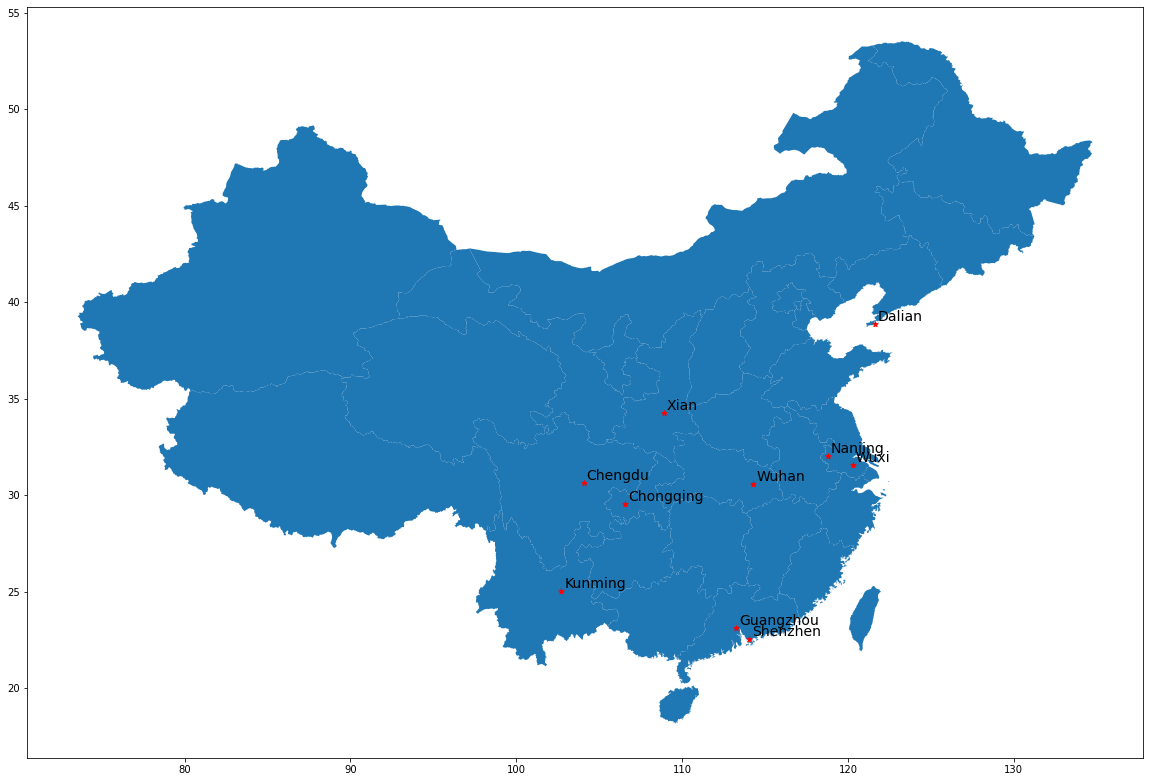

In [12]:
crs = {'init': 'epsg:4326'}
china_provinces_map = gpd.read_file("../map/provinces.zip")
china_provinces_map = china_provinces_map.to_crs(crs)

cities = pm_df["city"].unique()
cities_geodf = get_geodf_cities(cities)

fig, ax = plt.subplots(figsize=(20,17))
china_provinces_map.plot(ax=ax)
cities_geodf.plot(ax=ax, markersize = 30, color = 'red', marker = '*')
for x, y, label in zip(cities_geodf.geometry.x, cities_geodf.geometry.y, cities_geodf.city):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=14)